In [1]:
import torch
import numpy as np
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from data_modules.mind_aspect_data import MINDAspectDataModule, AspectNewsBatch
from modules.aspect_enc import AspectRepr
import tqdm
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [9]:
model = AspectRepr.load_from_checkpoint("/home/users1/hardy/hardy/project/vae/checkpoints/aspect_cat_sts-epoch=17-val_loss=1.7645.ckpt")  # Replace with your checkpoint path

mind = MINDAspectDataModule(
    test_path=Path('/home/users1/hardy/hardy/datasets/mind/MINDlarge_dev'),
    batch_size=32,
    selected_aspect='category_class'
)
mind.setup("test") 


In [10]:
from collections import defaultdict

# Load the trained model and dataset
 # Prepare the dataset

# Extract embeddings from the train dataset
embeddings = []
labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = model.to(device)  # Move the model to the appropriate device
limit = float('inf')  # Set a limit for the number of samples to process
i = 0
for batch in tqdm.tqdm(mind.test_dataloader()):
    # Move batch tensors to the same device as the model
    batch = AspectNewsBatch(batch)  # Ensure batch is of type NewsBatch
    batch["news"]["text"] = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in batch["news"]["text"].items()}
    batch['labels'] = batch['labels'].to(device)  # Move labels to the same device
    # batch = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in batch.items()}

    with torch.no_grad():
        # Forward pass to get embeddings
        batch_embeddings, _ = model.forward(batch)
        batch_embeddings = batch_embeddings.cpu().numpy()  # Move embeddings back to CPU for numpy
        batch_labels = batch["labels"].cpu().numpy()  # Move labels back to CPU for numpy
        embeddings.append(batch_embeddings)
        labels.append(batch_labels)
        i += len(batch_embeddings)
        if i >= limit:
            break
# Find the minimum count among all labels
labels_flat = np.concatenate(labels, axis=0) if isinstance(labels[0], (list, np.ndarray)) else labels
unique_labels, counts = np.unique(labels_flat, return_counts=True)
no_labels = len(unique_labels)
min_count = counts.min()

# Downsample each label to min_count

label_indices = defaultdict(list)
for idx, label in enumerate(labels_flat):
    label_indices[label].append(idx)

selected_indices = []
for label in unique_labels:
    indices = label_indices[label]
    if len(indices) > min_count:
        indices = np.random.choice(indices, min_count, replace=False)
    selected_indices.extend(indices)

selected_indices = np.array(selected_indices)

# Downsample embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)[selected_indices]
labels = labels_flat[selected_indices]
# # Concatenate all embeddings and labels
# embeddings = np.concatenate(embeddings, axis=0)
# labels = np.concatenate(labels, axis=0)


  0%|          | 0/2251 [00:00<?, ?it/s]/home/users1/hardy/hardy/project/vae/.venv/lib64/python3.13/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 2251/2251 [06:29<00:00,  5.79it/s]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

/home/users1/hardy/hardy/project/vae/.venv/lib64/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


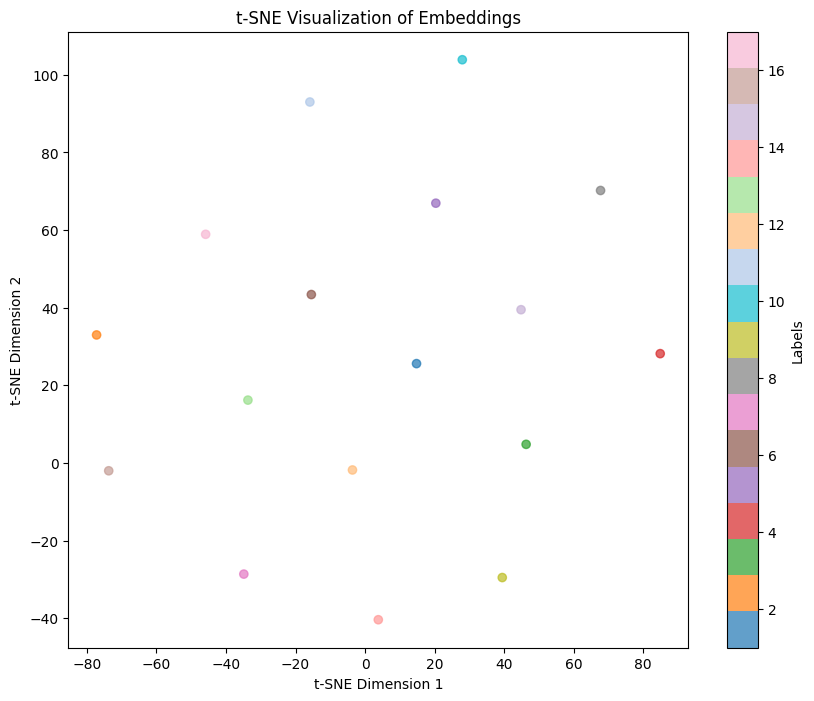

In [14]:
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7'
]
# point_colors = [custom_colors[label] for label in labels]
cmap = mcolors.ListedColormap(custom_colors[:no_labels])  # Create a colormap with the custom colors
# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap=cmap, alpha=0.7)
plt.colorbar(scatter, label="Labels")
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig("tsne_cat.png", format="png", dpi=300)

In [55]:
nembeddings = np.concatenate(embeddings, axis=0)[selected_indices]
nlabels = labels_flat[selected_indices]

In [57]:
nlabels

array([1, 1, 1, ..., 4, 4, 4], shape=(10584,))

In [63]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=no_labels, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

ari_score = adjusted_rand_score(labels, cluster_labels)
nmi_score = normalized_mutual_info_score(labels, cluster_labels)
v_measure = v_measure_score(labels, cluster_labels)

In [64]:
print(f"Adjusted Rand Index: {ari_score:.4f}")
print(f"Normalized Mutual Information: {nmi_score:.4f}")
print(f"V-measure: {v_measure:.4f}")

Adjusted Rand Index: 0.9607
Normalized Mutual Information: 0.9363
V-measure: 0.9363


In [66]:
print(no_labels)

4
